## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [26]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler


In [27]:
# Random state seed
rseed = 42

## Load and explore data

In [28]:
# Import the dataset
df = pd.read_csv('Country-data.csv', index_col=0)

# Check if data is read correctly
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [29]:
# Check the shape
print(df.shape)

(167, 9)


In [30]:
# Check datatypes & counts
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Afghanistan to Zambia
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 13.0+ KB


In [31]:
# Get descriptive statistics
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [32]:
# Identify any missing data
missing_column_counts = df.isnull().sum()

# Print counts of missing values for each column
print(missing_column_counts) 

# Check if there are any missing values and print missing values
if any(missing_column_counts > 0):     
    print('Columns with missing values: ',missing_column_counts[missing_column_counts > 0])

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


## Preprocessing and Feature Selection

In [33]:
# Drop any non-numeric features (columns)
df = df.select_dtypes(include='number')

# Print modified data with only numeric features
print("Modified Data with only numeric features ", end='\n\n')
print(df)

Modified Data with only numeric features 

                     child_mort  exports  health  imports  income  inflation  \
country                                                                        
Afghanistan                90.2     10.0    7.58     44.9    1610       9.44   
Albania                    16.6     28.0    6.55     48.6    9930       4.49   
Algeria                    27.3     38.4    4.17     31.4   12900      16.10   
Angola                    119.0     62.3    2.85     42.9    5900      22.40   
Antigua and Barbuda        10.3     45.5    6.03     58.9   19100       1.44   
...                         ...      ...     ...      ...     ...        ...   
Vanuatu                    29.2     46.6    5.25     52.7    2950       2.62   
Venezuela                  17.1     28.5    4.91     17.6   16500      45.90   
Vietnam                    23.3     72.0    6.84     80.2    4490      12.10   
Yemen                      56.3     30.0    5.18     34.4    4480      23.60 

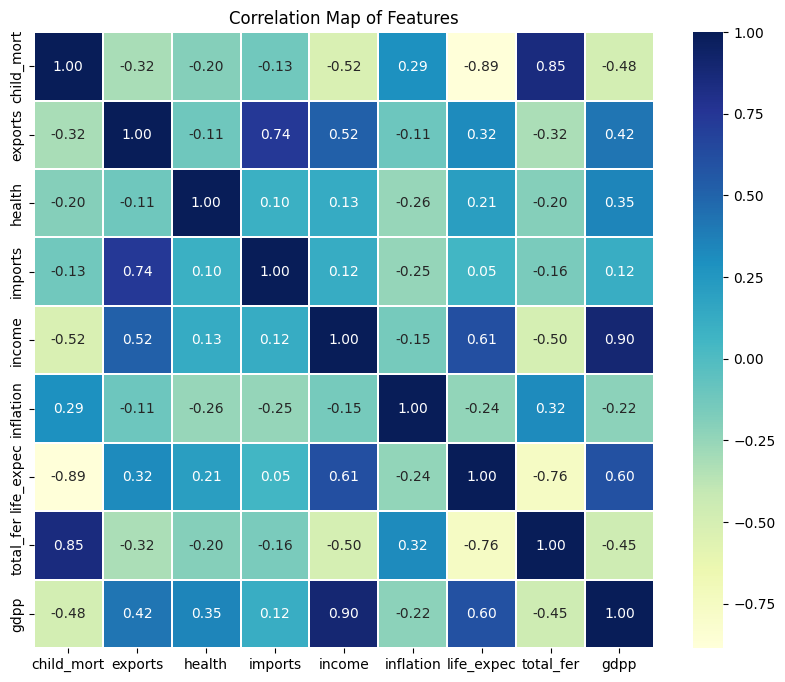

In [34]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap

# Create a correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidth=0.3)
plt.title('Correlation Map of Features')
plt.show()

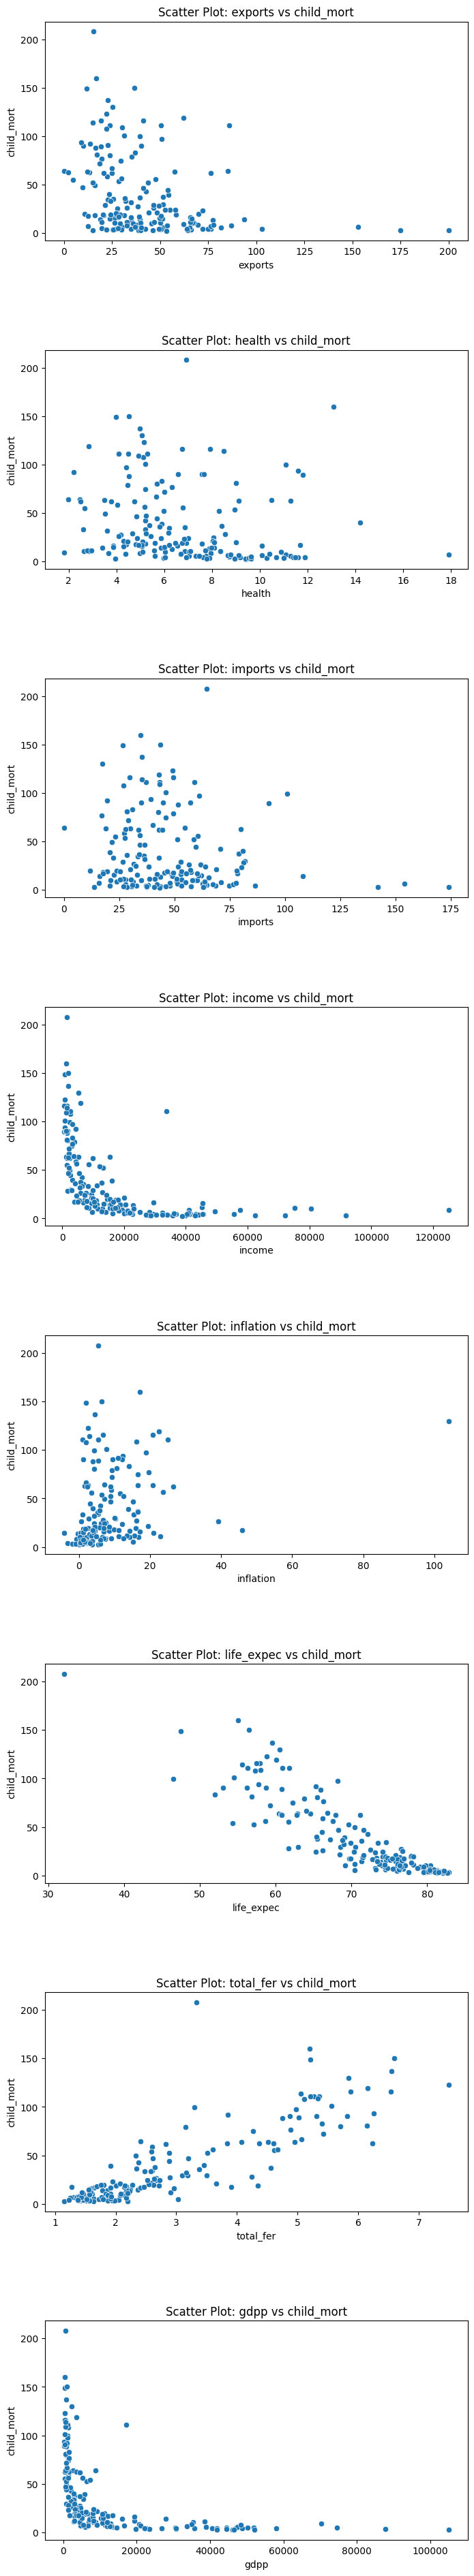

In [35]:
# Explore the continuous independent features against child_mort using scatter plots.

# Get list of continuous independent feature names (excluding child_mort)
continuous_features = df.columns[df.columns != 'child_mort']

# Set up subplots
fig, axes = plt.subplots(nrows=len(continuous_features), ncols=1, figsize=(8, 6 * len(continuous_features)))
plt.subplots_adjust(hspace=0.5)

# Create scatter plots
for i, feature in enumerate(continuous_features):
    plt.subplot(len(continuous_features), 1, i + 1)
    sns.scatterplot(x=feature, y='child_mort', data=df)
    plt.title(f'Scatter Plot: {feature} vs child_mort')
plt.show()    

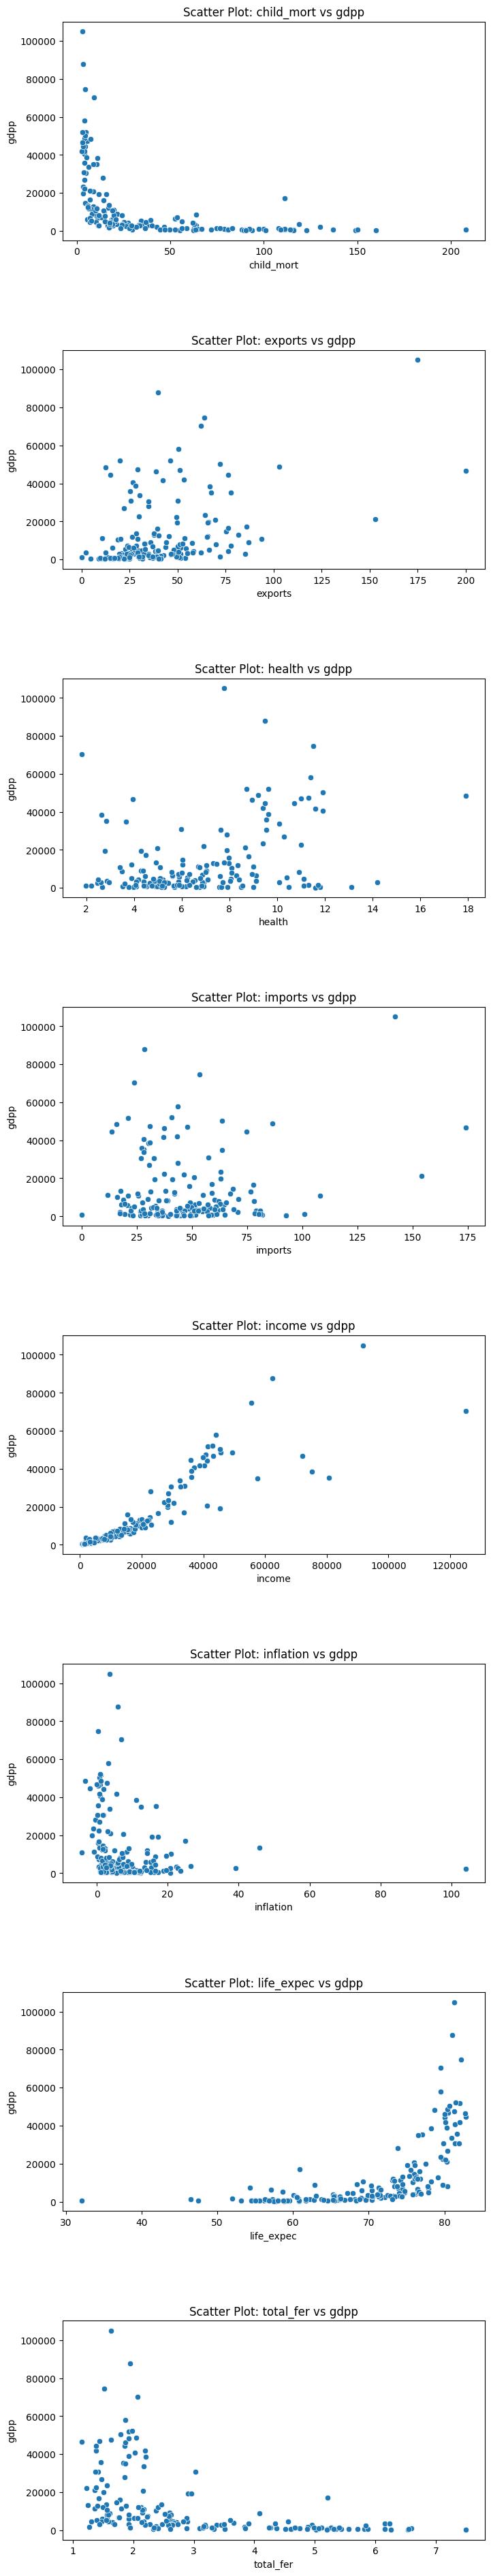

In [36]:
# Explore the continuous independent features against gdpp using scatter plots.
continuous_features = df.columns[df.columns != 'gdpp']

# Set up subplots
fig, axes = plt.subplots(nrows=len(continuous_features), ncols=1, figsize=(8, 6 * len(continuous_features)))
plt.subplots_adjust(hspace=0.5)

# Create scatter plots
for i, feature in enumerate(continuous_features):
    plt.subplot(len(continuous_features), 1, i + 1)
    sns.scatterplot(x=feature, y='gdpp', data=df)
    plt.title(f'Scatter Plot: {feature} vs gdpp')
plt.show()    

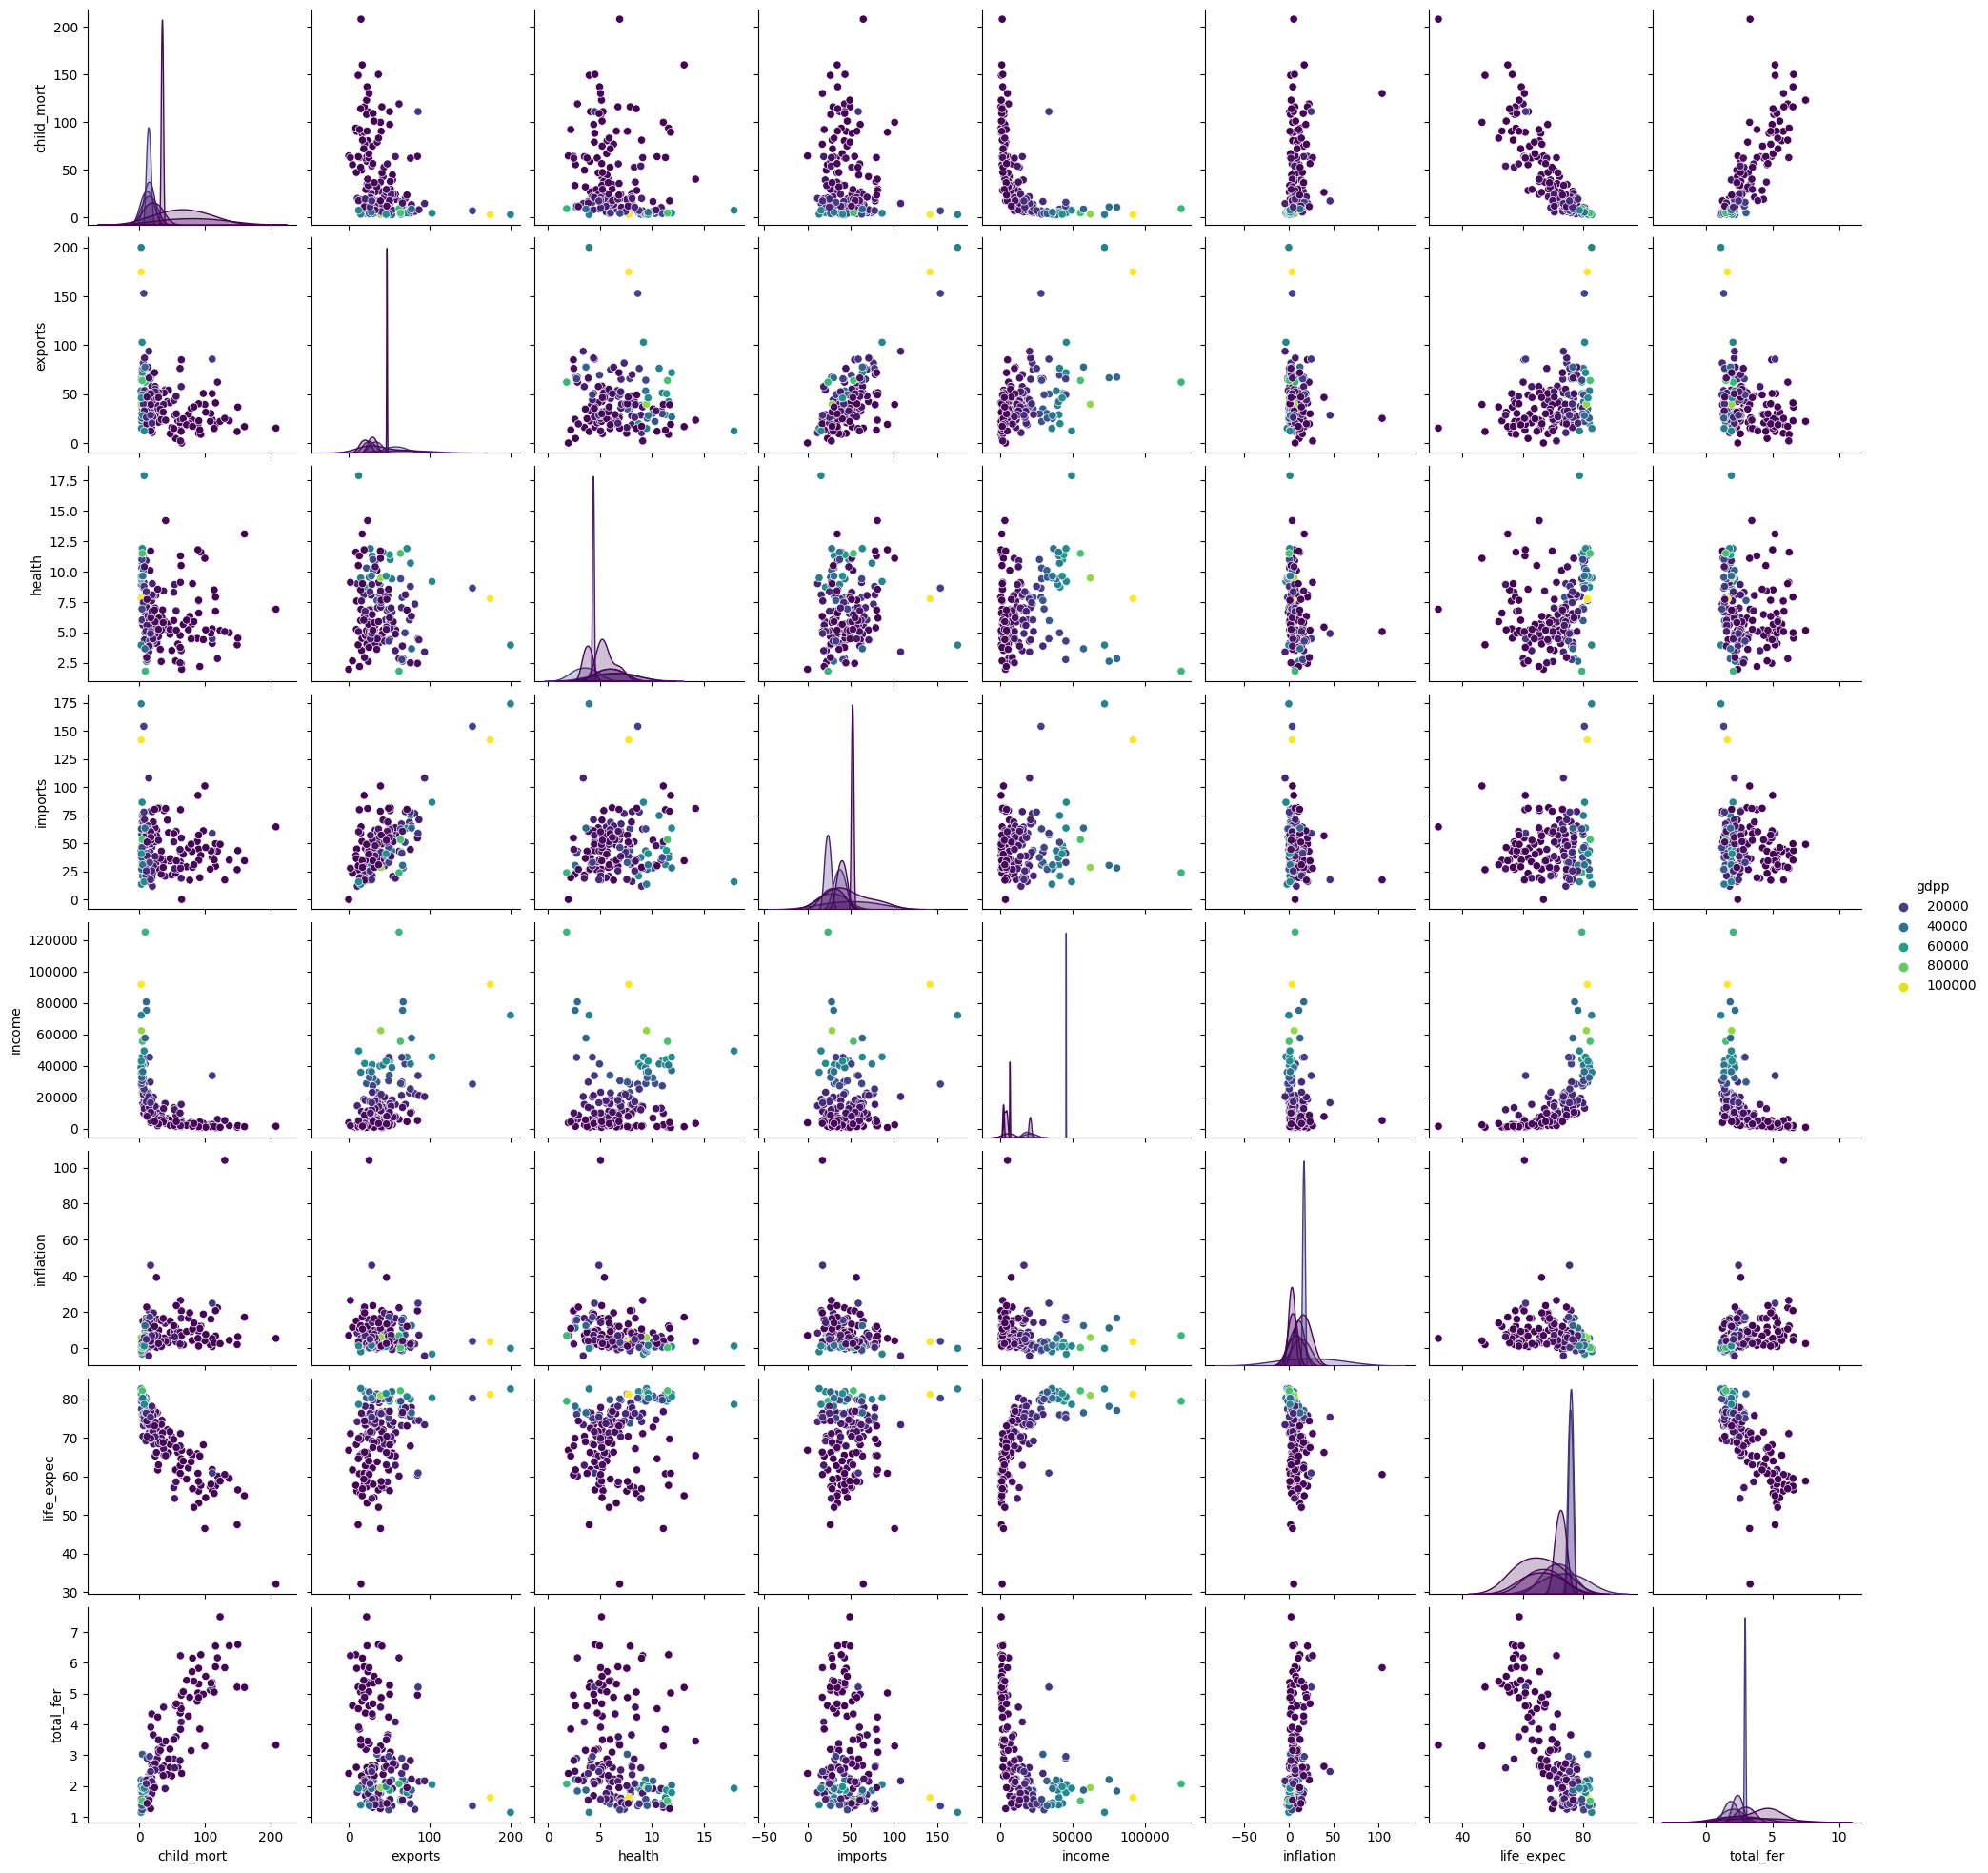

In [37]:
# Create a pair plot
# Hint: Explore seaborn pairplot

# Select continuous feature for the pair plot
features = df.columns[df.columns != 'gdpp']
features = features.insert(0, 'gdpp')

# Create a pairplot
sns.pairplot(df[features],hue='gdpp',palette='viridis')
plt.show()

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [38]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"

# Create a MixMaxScaler instance
scaler = MinMaxScaler()

# Select features to be normalized (excluding feature gdpp)
features_to_normalize = df.columns[df.columns != 'gdpp']

# Normalize the selected features
df_scaled = df.copy()
df_scaled[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# Display head of normalized dataframe
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,553
Albania,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,4090
Algeria,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,4460
Angola,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,3530
Antigua and Barbuda,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,12200


## K-Means Clustering

### Selecting K

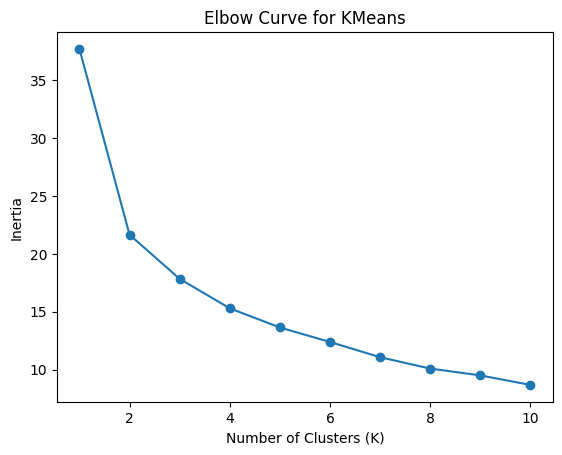

In [39]:
%matplotlib inline

# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Curve for KMeans')
    plt.show()

# Plot elbow curve using scaled dataset
elbow_Kmeans(df_scaled[features_to_normalize])

Silhoutte Score for k=2: 0.7914931873480167
Silhoutte Score for k=3: 0.7824423551241575
Silhoutte Score for k=4: 0.6843341596153921
Silhoutte Score for k=5: 0.6404342110687722
Silhoutte Score for k=6: 0.6381563827364416
Silhoutte Score for k=7: 0.634874867045165
Silhoutte Score for k=8: 0.5926328765767008
Silhoutte Score for k=9: 0.6043027170986113
Silhoutte Score for k=10: 0.6013536399947637


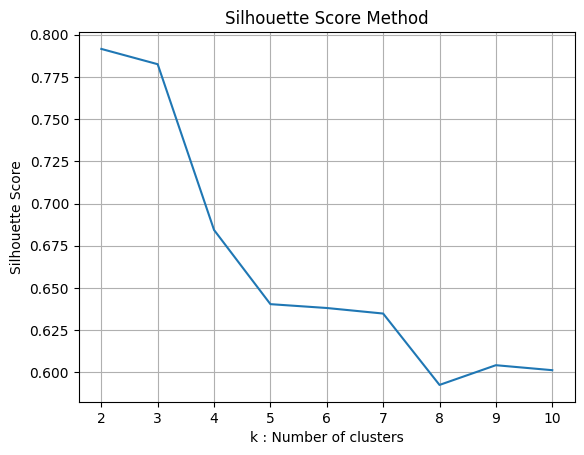

In [40]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_scaled, labels, metric='euclidean')
    sil.append(silhouette_avg)
    print(f"Silhoutte Score for k={k}: {silhouette_avg}")

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

We can see from elbow curve there is a distinctive bend at K = 2, signifying a point where additional clusters cease to provide substantial gains in explaining the variance.
We can see from silhoutte score that the value closest to +1 is when K = 2 (score = 0.7914931873480167)
We can therefore based on both methods arrive at a value for K = 2.

## Fitting a K-Means Model with the selected K value

In [41]:
# Remember to set the random_state to rseed
# Set the optimal number of clusters to 2 based on previous analysis using elbow and silhoutte method score
k_optimal = 2

# Create a KMeans model with the optimal number of clusters and set random_state to rseed
kmeans_optimal = KMeans(n_clusters=k_optimal, random_state=rseed, max_iter=500)

# Fit the KMeans model to the normalized dataset, considering only the selected features
kmeans_optimal.fit(df_scaled[features_to_normalize])

KMeans(max_iter=500, n_clusters=2, random_state=42)

In [42]:
# Count the number of records in each cluster

# Assign cluster labels to the original dataframe
df['cluster'] = kmeans_optimal.labels_

# Count the number of records in each cluster for analysis
cluster_counts = df['cluster'].value_counts()

# Display the number of records in each cluster 
print("Number of records in each cluster: ")
print(cluster_counts)

Number of records in each cluster: 
cluster
1    118
0     49
Name: count, dtype: int64


In [43]:
# Check model performance with the silhouette coefficient
silhouette_avg = silhouette_score(df_scaled[features_to_normalize], kmeans_optimal.labels_)
print(f"Silhouette coefficient for {k_optimal} clusters: {silhouette_avg}")

Silhouette coefficient for 2 clusters: 0.4181215898018909


## Predictions

In [44]:
# Add the predicted cluster label column to the original dataframe
# The 'cluster' column has already been assigned to original dataframe before counting the number of records. 
# Printing the head to view the cluster column
print(df.head())

                     child_mort  exports  health  imports  income  inflation  \
country                                                                        
Afghanistan                90.2     10.0    7.58     44.9    1610       9.44   
Albania                    16.6     28.0    6.55     48.6    9930       4.49   
Algeria                    27.3     38.4    4.17     31.4   12900      16.10   
Angola                    119.0     62.3    2.85     42.9    5900      22.40   
Antigua and Barbuda        10.3     45.5    6.03     58.9   19100       1.44   

                     life_expec  total_fer   gdpp  cluster  
country                                                     
Afghanistan                56.2       5.82    553        0  
Albania                    76.3       1.65   4090        1  
Algeria                    76.5       2.89   4460        1  
Angola                     60.1       6.16   3530        0  
Antigua and Barbuda        76.8       2.13  12200        1  


## Visualisation of clusters

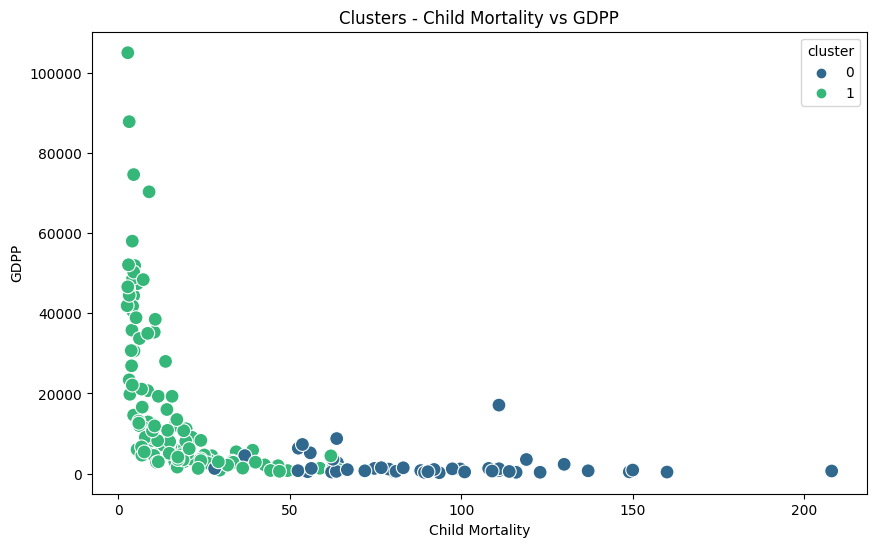

In [45]:
# Visualisation of clusters: Child mortality vs GDPP
plt.figure(figsize=(10,6))
sns.scatterplot(x='child_mort',y='gdpp',hue='cluster',data=df,palette='viridis',s=100)
plt.title('Clusters - Child Mortality vs GDPP')
plt.xlabel('Child Mortality')
plt.ylabel('GDPP')
plt.show()

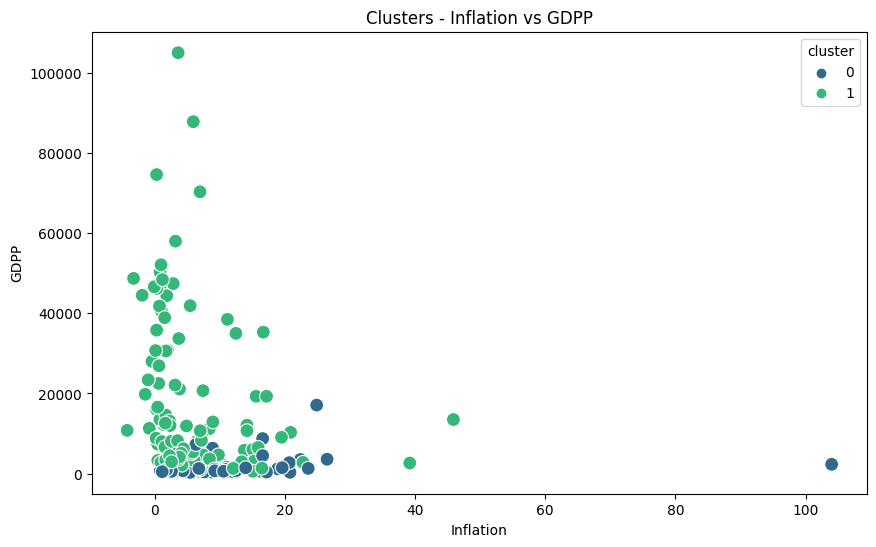

In [46]:
# Visualisation of clusters: Inflation vs GDPP
plt.figure(figsize=(10,6))
sns.scatterplot(x='inflation',y='gdpp',hue='cluster',data=df,palette='viridis',s=100)
plt.title('Clusters - Inflation vs GDPP')
plt.xlabel('Inflation')
plt.ylabel('GDPP')
plt.show()

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**

         child_mort          gdpp  inflation
cluster                                     
0         90.810204   1885.306122  11.923163
1         16.452542  17564.694915   6.062127


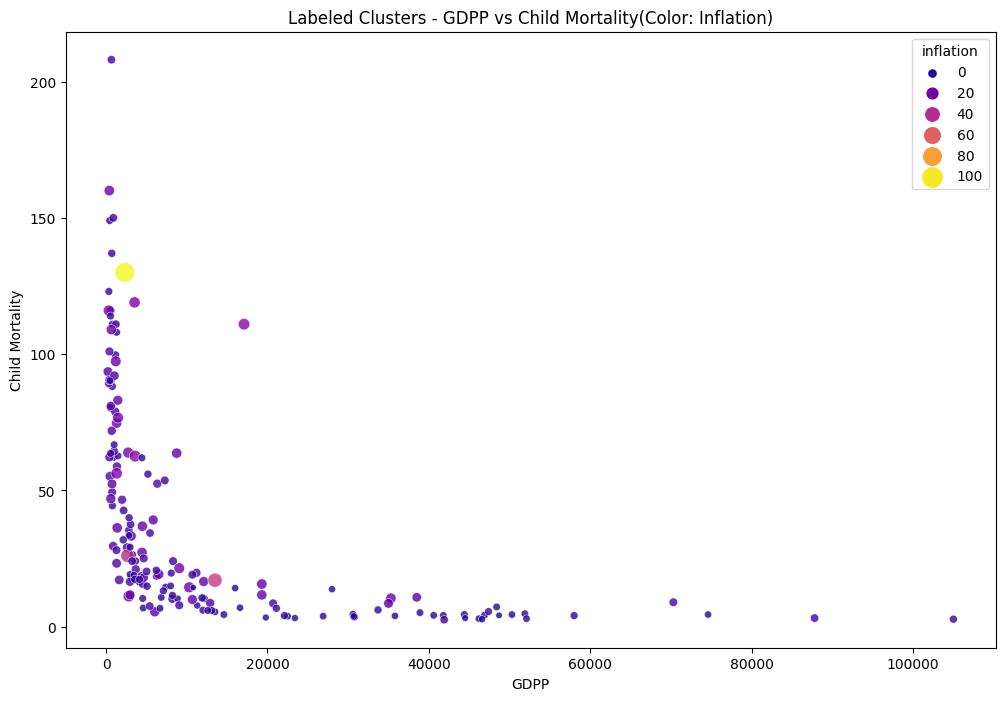

In [47]:
# Analyze the clusters
cluster_summary = df.groupby('cluster').agg({
    'child_mort': 'mean',
    'gdpp': 'mean',
    'inflation': 'mean'
}).sort_values('gdpp')

# Assign labels to clusters
label_mapping = {
    0: 'Least Developed',
    1: 'Developing-Developed',
}

df['cluster_label'] = 'Undefined'
df.loc[df['cluster'] == 0,'cluster_label'] = 'Low GDPP, High Child Mortality, High Inflation'
df.loc[df['cluster'] == 1,'cluster_label'] = 'High GDPP, Low Child Mortality, Low Inflation'

# Display the summary of each cluster
print(cluster_summary)

# Visualize the labeled clusters
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x='gdpp', y='child_mort', hue='inflation', size='inflation', data=df, palette='plasma', sizes=(20,200),alpha=0.8)
plt.title('Labeled Clusters - GDPP vs Child Mortality(Color: Inflation)')
plt.xlabel('GDPP')
plt.ylabel('Child Mortality')
plt.show()

As we can see when gdpp is low (around 1885.3) the child mortality is high (around 90.8) and inflation is also high around (11.9). When gdpp is high (around 17564.7) the child mortality is very low around (16.5) and inflation is also low (around 6). These are the labels visually shown in the plot above.